In [1]:
from pathlib import Path
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from superpoint.superpoint import SuperPoint
import torch
from module import MLP_module_4_short, MLP_module_8_short, MLP_module_16_short, MLP_module_4_long, MLP_module_8_long, MLP_module_16_long
torch.set_grad_enabled(False)
from superpoint.utils import load_image, rbd
from superpoint.lightglue import LightGlue

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import json
ckpt_file_path = '/home/koki/Sparse_Matcher/test_image/mlp_ckpt.json'
with open(ckpt_file_path, 'r') as json_file:
    ckpt_path_data = json.load(json_file)

In [5]:
dim = "8" # 8,16
mlp_len = "short" # short, long
pair = "pair" #nonpair


model_dict = {
    "short":{
        "4": MLP_module_4_short,
        "8": MLP_module_8_short,
        "16": MLP_module_16_short,
    },
    "long":{
        "4": MLP_module_4_long,
        "8": MLP_module_8_long,
        "16": MLP_module_16_long
    }
}
ckpt_path = ckpt_path_data[mlp_len][pair][dim]
ckpt = torch.load(ckpt_path)
model = model_dict[mlp_len][dim]()
model.to(device).eval()
model.load_state_dict(ckpt)


<All keys matched successfully>

## megadepth 簡單

#### raw

In [6]:
extractor = SuperPoint(max_num_keypoints=1024).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)

In [12]:
image_file_path = '/home/koki/Sparse_Matcher/test_image/test_images_pair.txt'
path_list = []
with open(image_file_path,'r') as file:
    paths = file.readlines()

result_paths = []
for line in paths:
    line = line.rstrip('\n')
    line = line.split()
    result_paths.append(line)

print(result_paths[0])

['/home/koki/Sparse_Matcher/test_image/DSC_0410.JPG', '/home/koki/Sparse_Matcher/test_image/DSC_0411.JPG']


In [13]:
image_path0 = result_paths[0][0]
image_path1 = result_paths[0][1]

In [14]:
image0 = load_image(image_path0)
image1 = load_image(image_path1)


feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))


matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]
matches_no_mlp = matches01["matches"]
print(matches_no_mlp.shape)

torch.Size([464, 2])


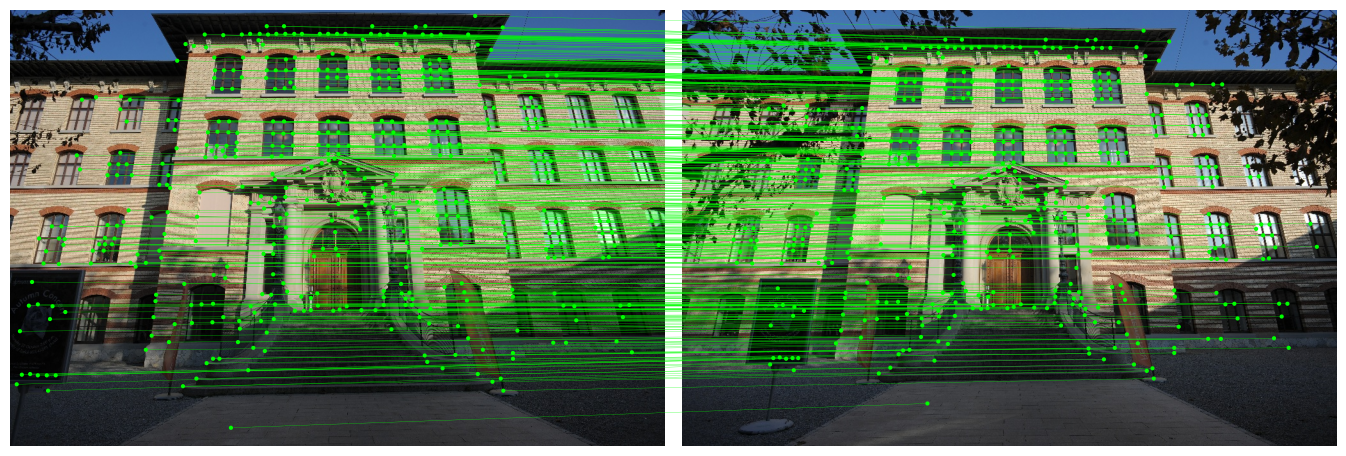

In [15]:
import superpoint.viz2d as viz2d

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)

#### mlp

In [16]:
image0 = load_image(image_path0)
image1 = load_image(image_path1)

extractor = SuperPoint(max_num_keypoints=1024).eval().to(device)
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))



_, feats0['descriptors'] = model(feats0['descriptors'])
_, feats1['descriptors'] = model(feats1['descriptors'])


matcher = LightGlue(features="superpoint").eval().to(device)
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]
matches_with_mlp = matches01["matches"]
print(matches_with_mlp.shape)

torch.Size([490, 2])


In [17]:
def count_same_pairs(tensor1, tensor2):
    equality_matrix = (tensor1.unsqueeze(1) == tensor2.unsqueeze(0)).all(dim=2)
    num_same_pairs = torch.sum(equality_matrix)
    return num_same_pairs.item()

result = count_same_pairs(matches_with_mlp, matches_no_mlp)
print("Number of same pairs:", result)

Number of same pairs: 456


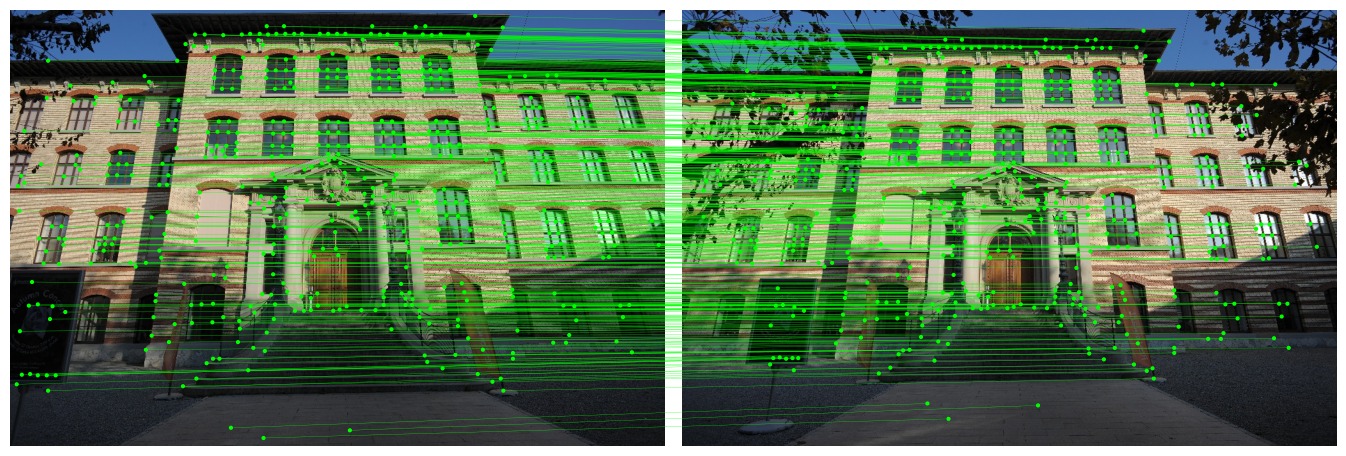

In [18]:
import superpoint.viz2d as viz2d

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)

